In [42]:
IJulia.load("utils.jl")

## Code imports and definitions, skip down for plots

In [ ]:
using Boltzmann
import Boltzmann.generate
using Statistics
using LinearAlgebra
using Images

# we need to reshape weights/samples for visualization purposes
function reshape_mnist(samples; c=10, r=10, h=28, w=28)
  f = zeros(r*h,c*w)
  for i=1:r, j=1:c
    f[(i-1)*h+1:i*h,(j-1)*w+1:j*w] = reshape(samples[:,(i-1)*c+j],h,w)'
  end
  w_min = minimum(samples)
  w_max = maximum(samples)
  scale = x -> (x-w_min)/(w_max-w_min)
  map!(scale,f,f)
  colorview(Gray,f)
end

function missing_mask(d, ratio)
  sample(1:d, floor(Int, d * ratio), replace = false)
end

function get_lossy(X, mask)
  lossy = deepcopy(X)

  ##### WTF?!?!?!?! ################################
  # WHY DOESN'T THIS WORK?!?!?!?!
  #throw_away = repeat(mask, outer = (1, size(X, 2)))
  #lossy[throw_away] = zero(throw_away)
  ##################################################
  for j in 1:size(lossy, 2), i in 1:length(mask)
    lossy[mask[i], j] = 0.0
  end

  lossy
end

function generate(rbm, X, mask; n_gibbs = 1)
  lossy = get_lossy(X, mask)
  obs = setdiff(1:size(X, 1), mask)
  
  keep = repeat(obs, outer = (1, size(X, 2)))

  for i = 1:n_gibbs	  
    lossy = generate(rbm, lossy, n_gibbs = 1)  
    for j in 1:size(lossy, 2), k in 1:length(obs)
      lossy[obs[k], j] = X[obs[k], j]
    end
  end

  lossy
end

function RE(rbm, X, mask)
  gen = generate(rbm, X, mask, n_gibbs = 1)
  mean((norm(gen[:, i] - X[:, i]) for i = 1:size(X, 2)))
end


In [70]:
using Images
using Plots

include("utils.jl")
include("data_load.jl")
include("hyper_search.jl")
include("../rbm/mf-rbm/mf.jl")

pyplot();

In [78]:
function generate_fps(rbm, X; n_iter = 1, ϵ = 1e-8)
  fp_iter(rbm, Float64.(X), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = n_iter)
end

function generate_fps(rbm, X, mask; n_iter = 1, ϵ = 1e-8)
  lossy = get_lossy(X, mask)
  obs = setdiff(1:size(X, 1), mask)
  
  keep = repeat(obs, outer = (1, size(X, 2)))
    
  mh = []

  for i = 1:n_iter
    lossy, mh = generate_fps(rbm, lossy, n_iter = 1, ϵ = 1e-8)
    for j in 1:size(lossy, 2), k in 1:length(obs)
      lossy[obs[k], j] = X[obs[k], j]
    end
  end

  lossy, mh
end;

In [72]:
# parameters used
params = Dict(
  :lr => [1e-4, 1e-5, 1e-6],
  :n_epochs => [2000],
  :batch_size => [20, 30, 40],
  :randomize => [true],
  :scorer => [Boltzmann.pseudo_likelihood],
  :update => [update_simple!],
  :ratio => [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
  :n_gibbs => [1, 3, 5]
);

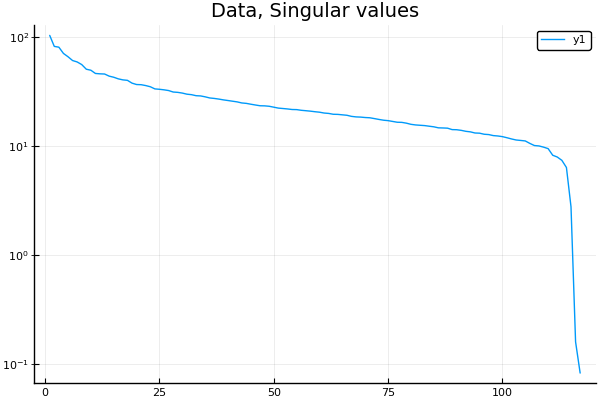

In [75]:
ns = 10000

x, labels = load_yeast(set = "test")
X = vcat(x, labels)

ns = size(X, 2)

m = mean(X, dims = 2)
s = mapslices(std, X, dims = 2)

X = (X .- m) ./ s

dir = "yeast"
try
  mkdir(dir)
catch end

# sanity check for data transformation
U, s, V = svd(X)
plot(s, yscale = :log10, title = "Data, Singular values")

#train_all(IsingRBM, X, params, fn = "$dir/MNIST_")

In [12]:
ratios = params[:ratio]

models = load_all(dir, IsingRBM)

m = [filter(x ->  (x[2][:ratio] == string(r)), collect(models)) for r in ratios]

masks = [missing_mask(size(X, 1), r) for r in ratios]

scored = [score_models(m[i], (rbm, X) -> RE(rbm, X, masks[i])) for i = 1:length(ratios)];

In [68]:
function get_best(models)
  scores = map(x -> x[3], models)
  models[findmin(scores)[2]]
end

best = [get_best(models) for models in scored];

In [76]:
function seq_sampling(rbm, mask, steps, ic = 2 * rand(size(X, 1), 1))
  s = deepcopy(ic)
  gen = [(s = generate(rbm, s, n_gibbs = i); s) for i in steps]
  [ic, gen...]
end;

## Reconstruction error

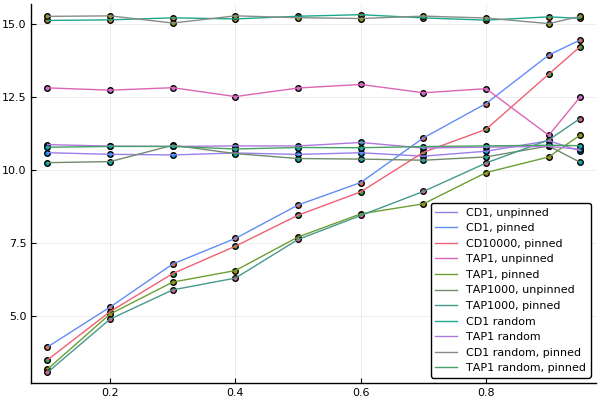

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [94]:
random = IsingRBM(size(X, 1), 100; X = X)

generators = [
    ((rbm, X, mask) -> generate(rbm, X, n_gibbs = 1), "CD1, unpinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 1), "CD1, pinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 10000), "CD10000, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1)[1], "TAP1, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1)[1], "TAP1, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1000)[1], "TAP1000, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1000)[1], "TAP1000, pinned"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random, pinned"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random, pinned")
]

function RE_archetype(rbm::AbstractRBM{T,V,H}, X, mask, generator) where {T,V,H}
  gen = generator(rbm, T.(X), mask)
  mean((norm(gen[:, i] - X[:, i]) for i = 1:size(X, 2)))
end

masks = [missing_mask(size(X, 1), r) for r in ratios]

REs = [[RE_archetype(best[i][1], X[:, rand(1:ns, 100)], masks[i], generator) for i = 1:length(best)] for (generator, lab) in generators]
labs = [lab for (_, lab) in generators]

labs = reshape(labs, 1, length(labs))

scatter(ratios, hcat(REs...), label = map(x -> "", labs))
plot!(ratios, hcat(REs...), lab = labs, leg = true)

## Reconstructions

### CD-1

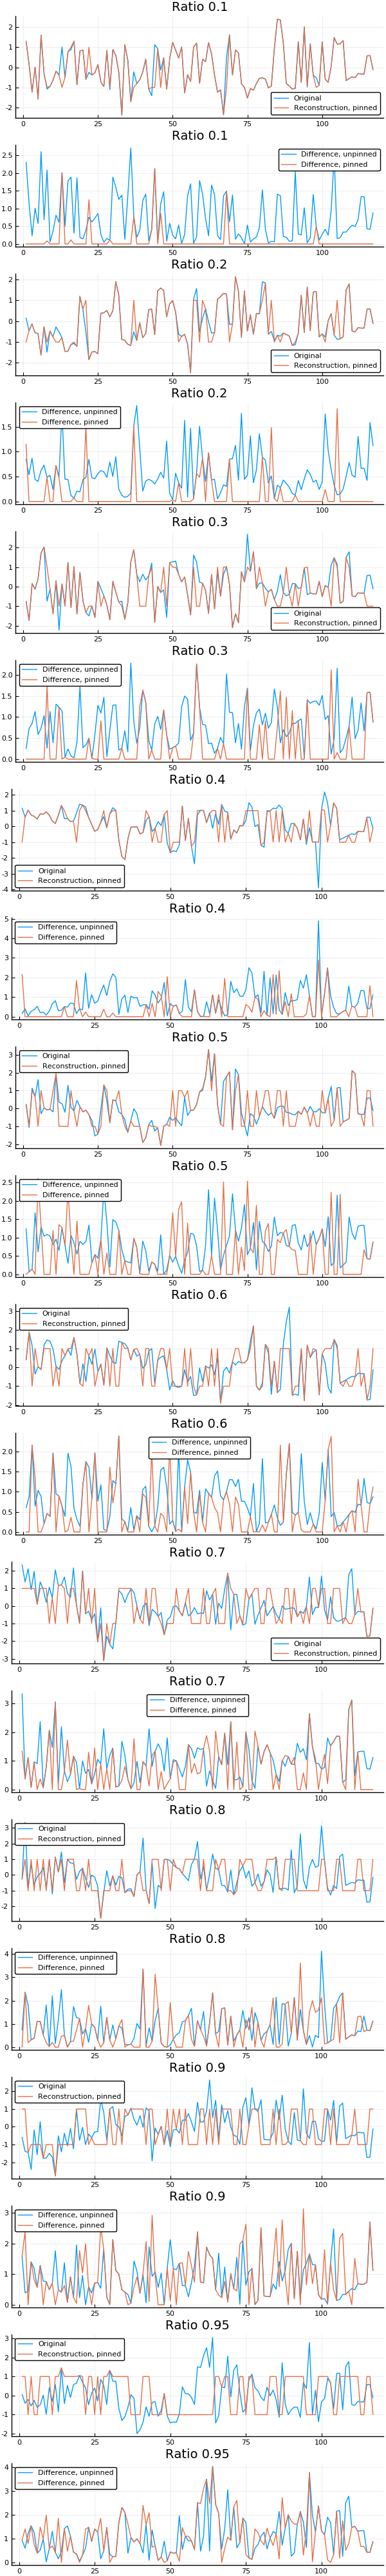

In [58]:
n = 1
p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  lossy = get_lossy(s, masks[i])
  gen = generate(best[i][1], lossy, n_gibbs = 1)
  gen_pin = generate(best[i][1], lossy, masks[i], n_gibbs = 1)
  vis = hcat(s, gen_pin)
  diff = hcat(abs.(gen - s), abs.(gen_pin - s))
  labels = ["Original" "Reconstruction, pinned"] # "Reconstruction, unpinned"
  push!(p, plot(plot(vis, lab = labels), plot(diff, lab = ["Difference, unpinned" "Difference, pinned"]), title = "Ratio $(ratios[i])", layout = (2, 1)))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### CD-10000

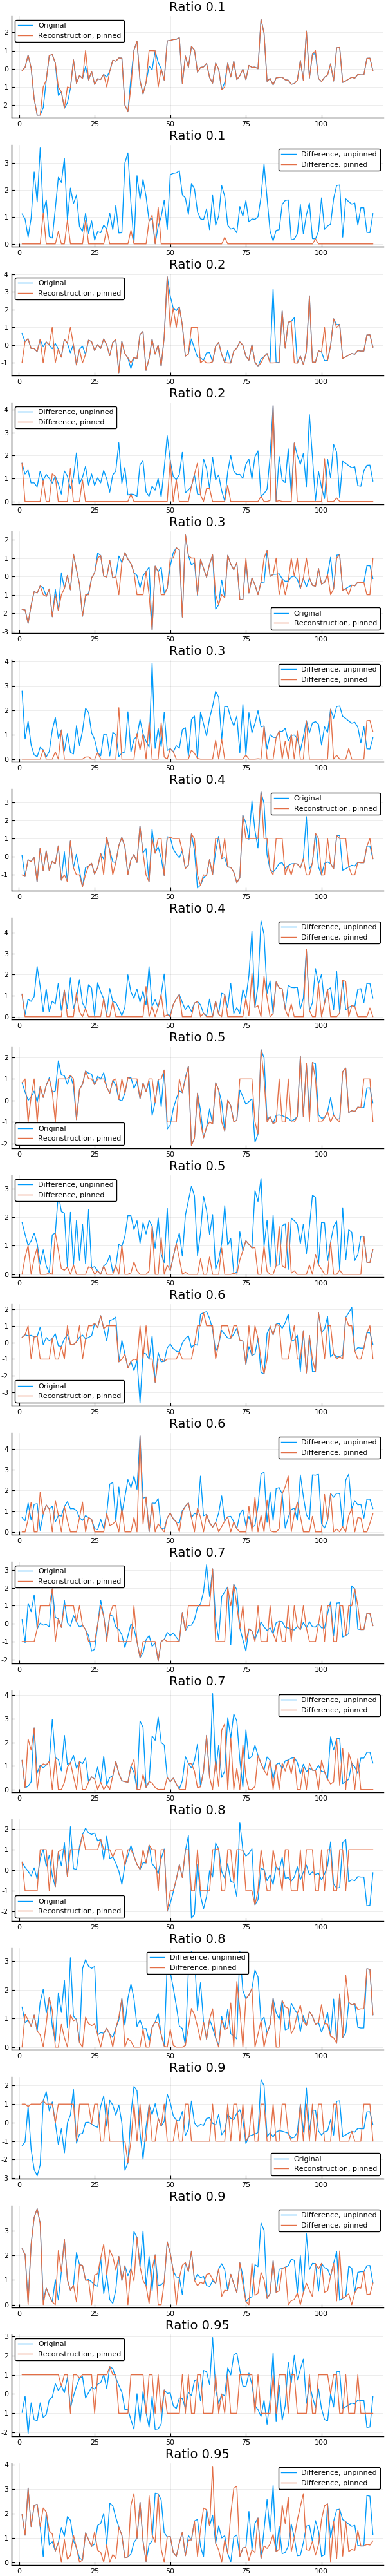

In [57]:
n_gibbs = 10000

n = 1
p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  lossy = get_lossy(s, masks[i])
  gen = generate(best[i][1], lossy, n_gibbs = n_gibbs)
  gen_pin = generate(best[i][1], lossy, masks[i], n_gibbs = n_gibbs)
  vis = hcat(s, gen_pin)
  diff = hcat(abs.(gen - s), abs.(gen_pin - s))
  labels = ["Original" "Reconstruction, pinned"] # "Reconstruction, unpinned"
  push!(p, plot(plot(vis, lab = labels), plot(diff, lab = ["Difference, unpinned" "Difference, pinned"]), title = "Ratio $(ratios[i])", layout = (2, 1)))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### TAP-1

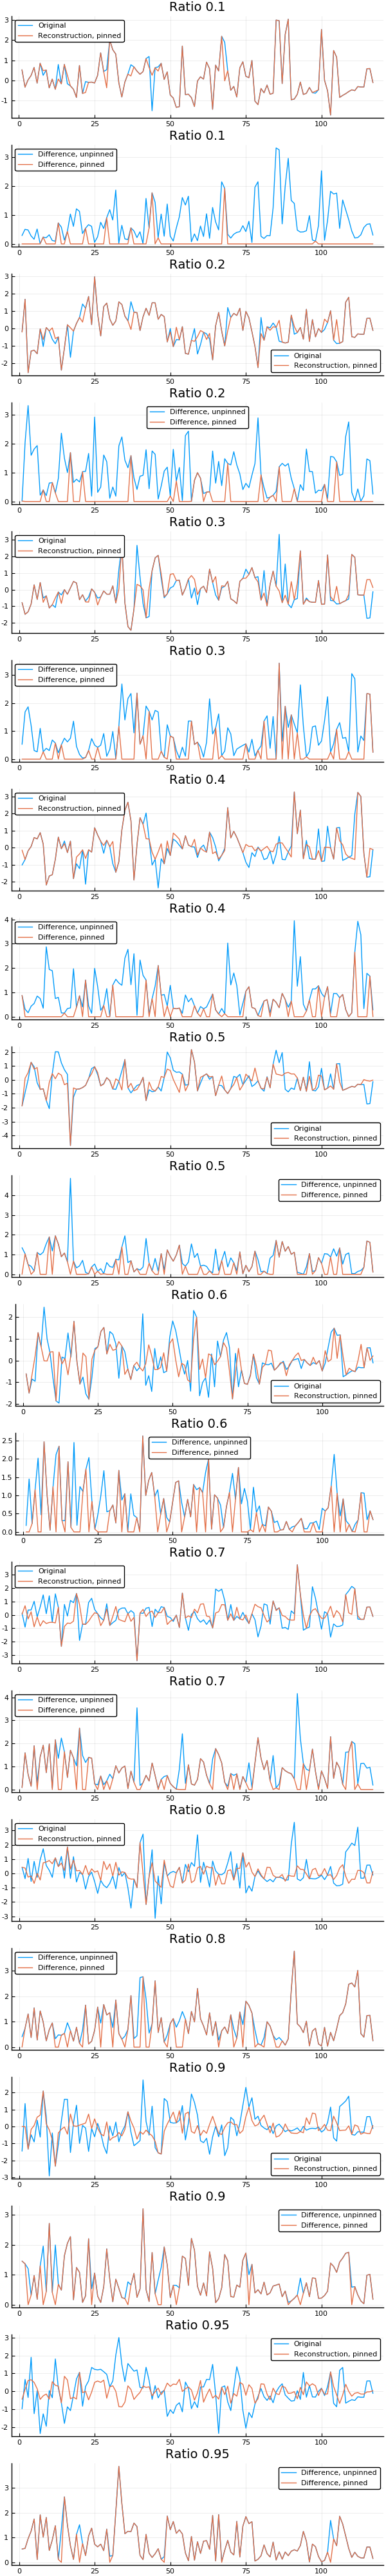

In [60]:
n = 1

ϵ = 1e-8
max_iter = 1

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  vis = hcat(s, pinned_fps)
  diff = hcat(abs.(fps - s), abs.(pinned_fps - s))
  labels = ["Original" "Reconstruction, pinned"] # "Reconstruction, unpinned"
  push!(p, plot(plot(vis, lab = labels), plot(diff, lab = ["Difference, unpinned" "Difference, pinned"]), title = "Ratio $(ratios[i])", layout = (2, 1)))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

## TAP-10

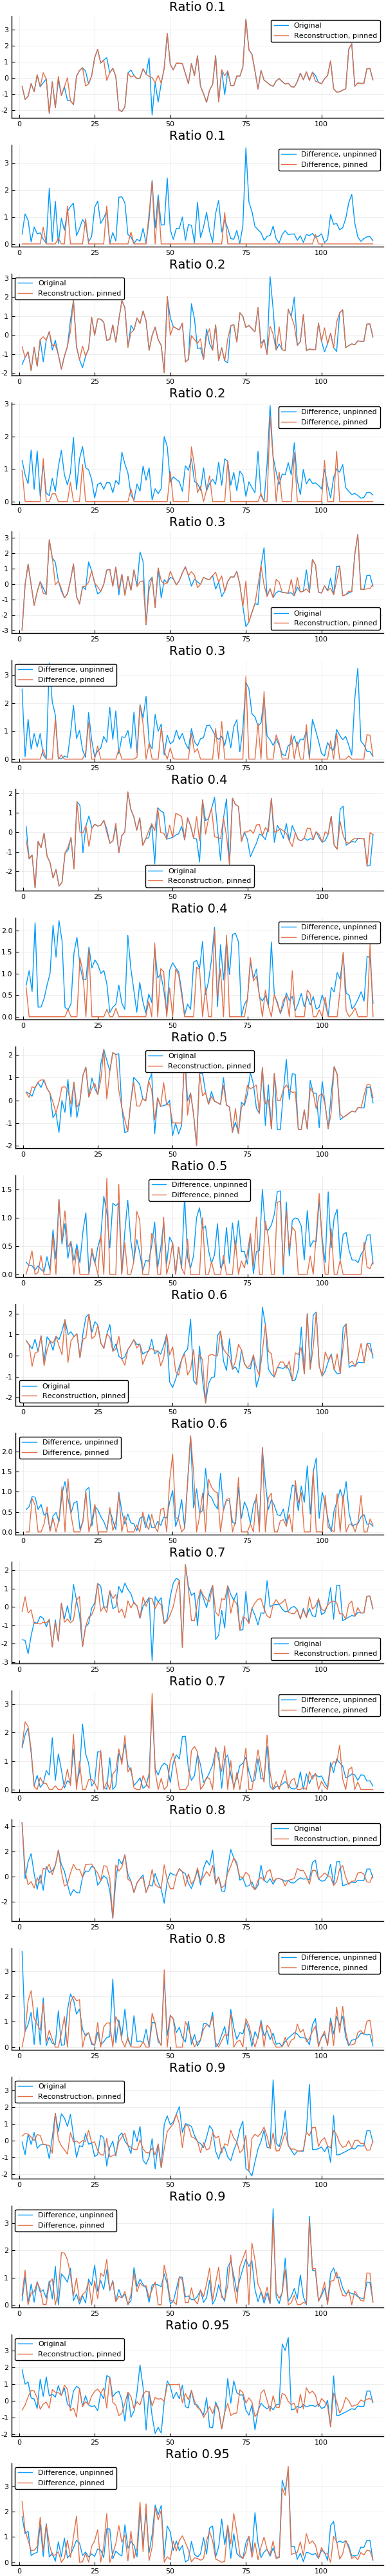

In [62]:
n = 1

ϵ = 1e-8
max_iter = 10

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  vis = hcat(s, pinned_fps)
  diff = hcat(abs.(fps - s), abs.(pinned_fps - s))
  labels = ["Original" "Reconstruction, pinned"] # "Reconstruction, unpinned"
  push!(p, plot(plot(vis, lab = labels), plot(diff, lab = ["Difference, unpinned" "Difference, pinned"]), title = "Ratio $(ratios[i])", layout = (2, 1)))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### Converged TAP

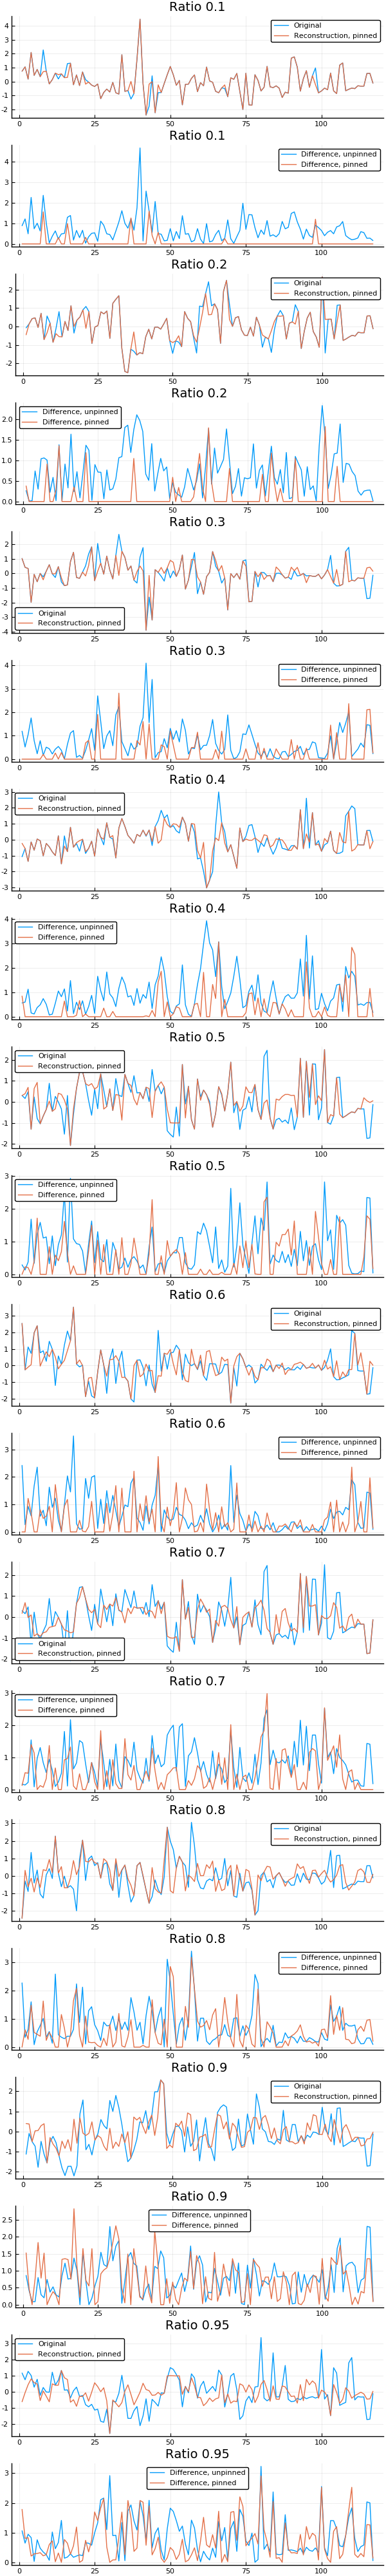

In [65]:
n = 1

ϵ = 1e-8
max_iter = 100000

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  vis = hcat(s, pinned_fps)
  diff = hcat(abs.(fps - s), abs.(pinned_fps - s))
  labels = ["Original" "Reconstruction, pinned"] # "Reconstruction, unpinned"
  push!(p, plot(plot(vis, lab = labels), plot(diff, lab = ["Difference, unpinned" "Difference, pinned"]), title = "Ratio $(ratios[i])", layout = (2, 1)))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

## ROC AUC scores

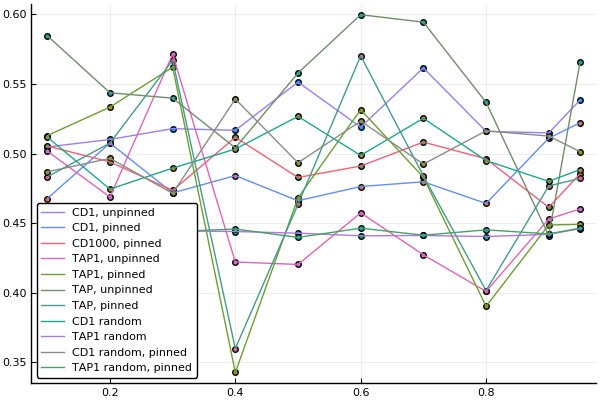

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [93]:
using ScikitLearn
@sk_import metrics: roc_auc_score

random = IsingRBM(size(X, 1), 100; X = X)

generators = [
    ((rbm, X, mask) -> generate(rbm, X, n_gibbs = 1), "CD1, unpinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 1), "CD1, pinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 1000), "CD1000, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1)[1], "TAP1, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1)[1], "TAP1, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1000)[1], "TAP, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1000)[1], "TAP, pinned"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random, pinned"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random, pinned")
]

function roc_auc(rbm::AbstractRBM{T,V,H}, X, mask, generator; average = "macro") where {T,V,H}
  gen = generator(rbm, T.(X), mask)[104:end, :]
  roc_auc_score(labels, gen, average = average)
end

masks = [missing_mask(size(X, 1), r) for r in ratios]

#scores = [[roc_auc(best[i][1], X[:, rand(1:ns, 100)], masks[i], generator) for i = 1:length(best)] for (generator, lab) in generators]
labs = [lab for (_, lab) in generators]

labs = reshape(labs, 1, length(labs))

scatter(ratios, hcat(scores...), label = map(x -> "", labs))
plot!(ratios, hcat(scores...), lab = labs, leg = true)